In [32]:
import pandahouse
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm  # Прогресс-бар
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
import swifter # Ускорялка метода apply
from scipy import stats # Статистика
from scipy.stats import norm, ttest_ind
%matplotlib inline
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250220'
}

Задача: 
Коллеги из ML-отдела планируют внедрить новый алгоритм, который увеличивает количество просмотров у части пользователей. Есть предположение, что рост просмотров повлечёт за собой рост количества лайков на пользователя.

Цель — оценить, сможем ли мы зафиксировать это изменение в среднем числе лайков на пользователя, используя t-тест. Для этого моделируем ситуацию с помощью симуляции Монте-Карло, используя данные из A/A и A/B периода (24.01.2025 – 06.02.2025). Размер выборки увеличен вдвое по сравнению с первой симуляцией, т.к. эксперимент теперь длится 2 недели.

Распределения просмотров и CTR из A/A-периода (24.01.2025 – 30.01.2025). 
Количество симуляций: 20 000.

<Axes: ylabel='Count'>

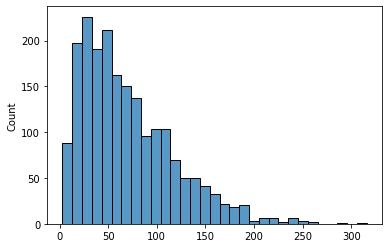

In [53]:
# Распределение просмотров пользователей за A/A-период

q_views = """
select views, count() as users
from (select
    user_id,
    sum(action = 'view') as views
from {db}.feed_actions
where toDate(time) between '2025-01-24' AND '2025-01-30'
group by user_id
)
group by views
order by views
"""
views = pandahouse.read_clickhouse(q_views, connection=connection)
views['p'] = views['users']/views.users.sum()

# Отображение графика для демонстрации
views_distr = stats.rv_discrete(name='views_distr', 
                                values=(views['views'], 
                                        views['p']))
sns.histplot(views_distr.rvs(size=2000))

In [54]:
# Распределение поюзерного CTR за A/A-период
q_ctr = """
select 
   floor(ctr, 2) as ctr, count() as users
from (select toDate(time) as dt, 
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from {db}.feed_actions
where dt between '2025-01-24' AND '2025-01-30'
group by dt,user_id
)
group by ctr
"""

ctr = pandahouse.read_clickhouse(q_ctr, connection=connection)

# Нормирование вероятности для дискретных распределений
views['p'] = views['users'] / views['users'].sum() 
ctr['p'] = ctr['users'] / ctr['users'].sum() 

In [55]:
# Количество пользователей за весь период 24.01-06.02
q_count_user= """
SELECT count(DISTINCT user_id) as total_users
FROM {db}.feed_actions
WHERE toDate(time) BETWEEN '2025-01-24' AND '2025-02-06'

"""

count_users = pandahouse.read_clickhouse(q_count_user, connection=connection)
total_users = int(count_users.iloc[0, 0])

In [56]:
# Симуляция Монте-Карло для оценки мощности теста
rng = np.random.default_rng()

n=total_users//2
num_simulations = 20000
result_list = []
    
for i in tqdm(range(num_simulations)):
    # Генерирация просмотров и CTR из реальных распределений
    group_A_views = rng.choice(views['views'], size=n, replace=True, p=views['p']).astype(np.int64)
    group_B_views = rng.choice(views['views'], size=n, replace=True, p=views['p']).astype(np.int64)
    
    # Моделирование эффекта алгоритма в группе B (1–2 доп. просмотра при условии >= 30)
    group_B_views = group_B_views + ((1 + rng.binomial(1, 0.5, size=n)) * rng.binomial(1, 0.9, size=n)) * (group_B_views >= 30)
    
    group_A_ctr = rng.choice(ctr['ctr'], size=n, replace=True, p=ctr['p'])
    group_B_ctr = rng.choice(ctr['ctr'], size=n, replace=True, p=ctr['p'])
    
    # Генерация количества лайков
    group_A_likes = rng.binomial(group_A_views, group_A_ctr)
    group_B_likes = rng.binomial(group_B_views, group_B_ctr)
    
    # t-тест с поправкой на неравные дисперсии
    result_list.append(stats.ttest_ind(group_B_likes, group_A_likes, equal_var=False).pvalue < 0.05)

# Расчёт мощности теста
result = (sum(result_list) / num_simulations) * 100
print(f"Финальный результат: мощность теста {result:.2f} %")

100%|██████████| 20000/20000 [07:14<00:00, 46.03it/s]

Финальный результат: мощность теста 56.36 %
